# Probabilistic Mission Design - Quick Start

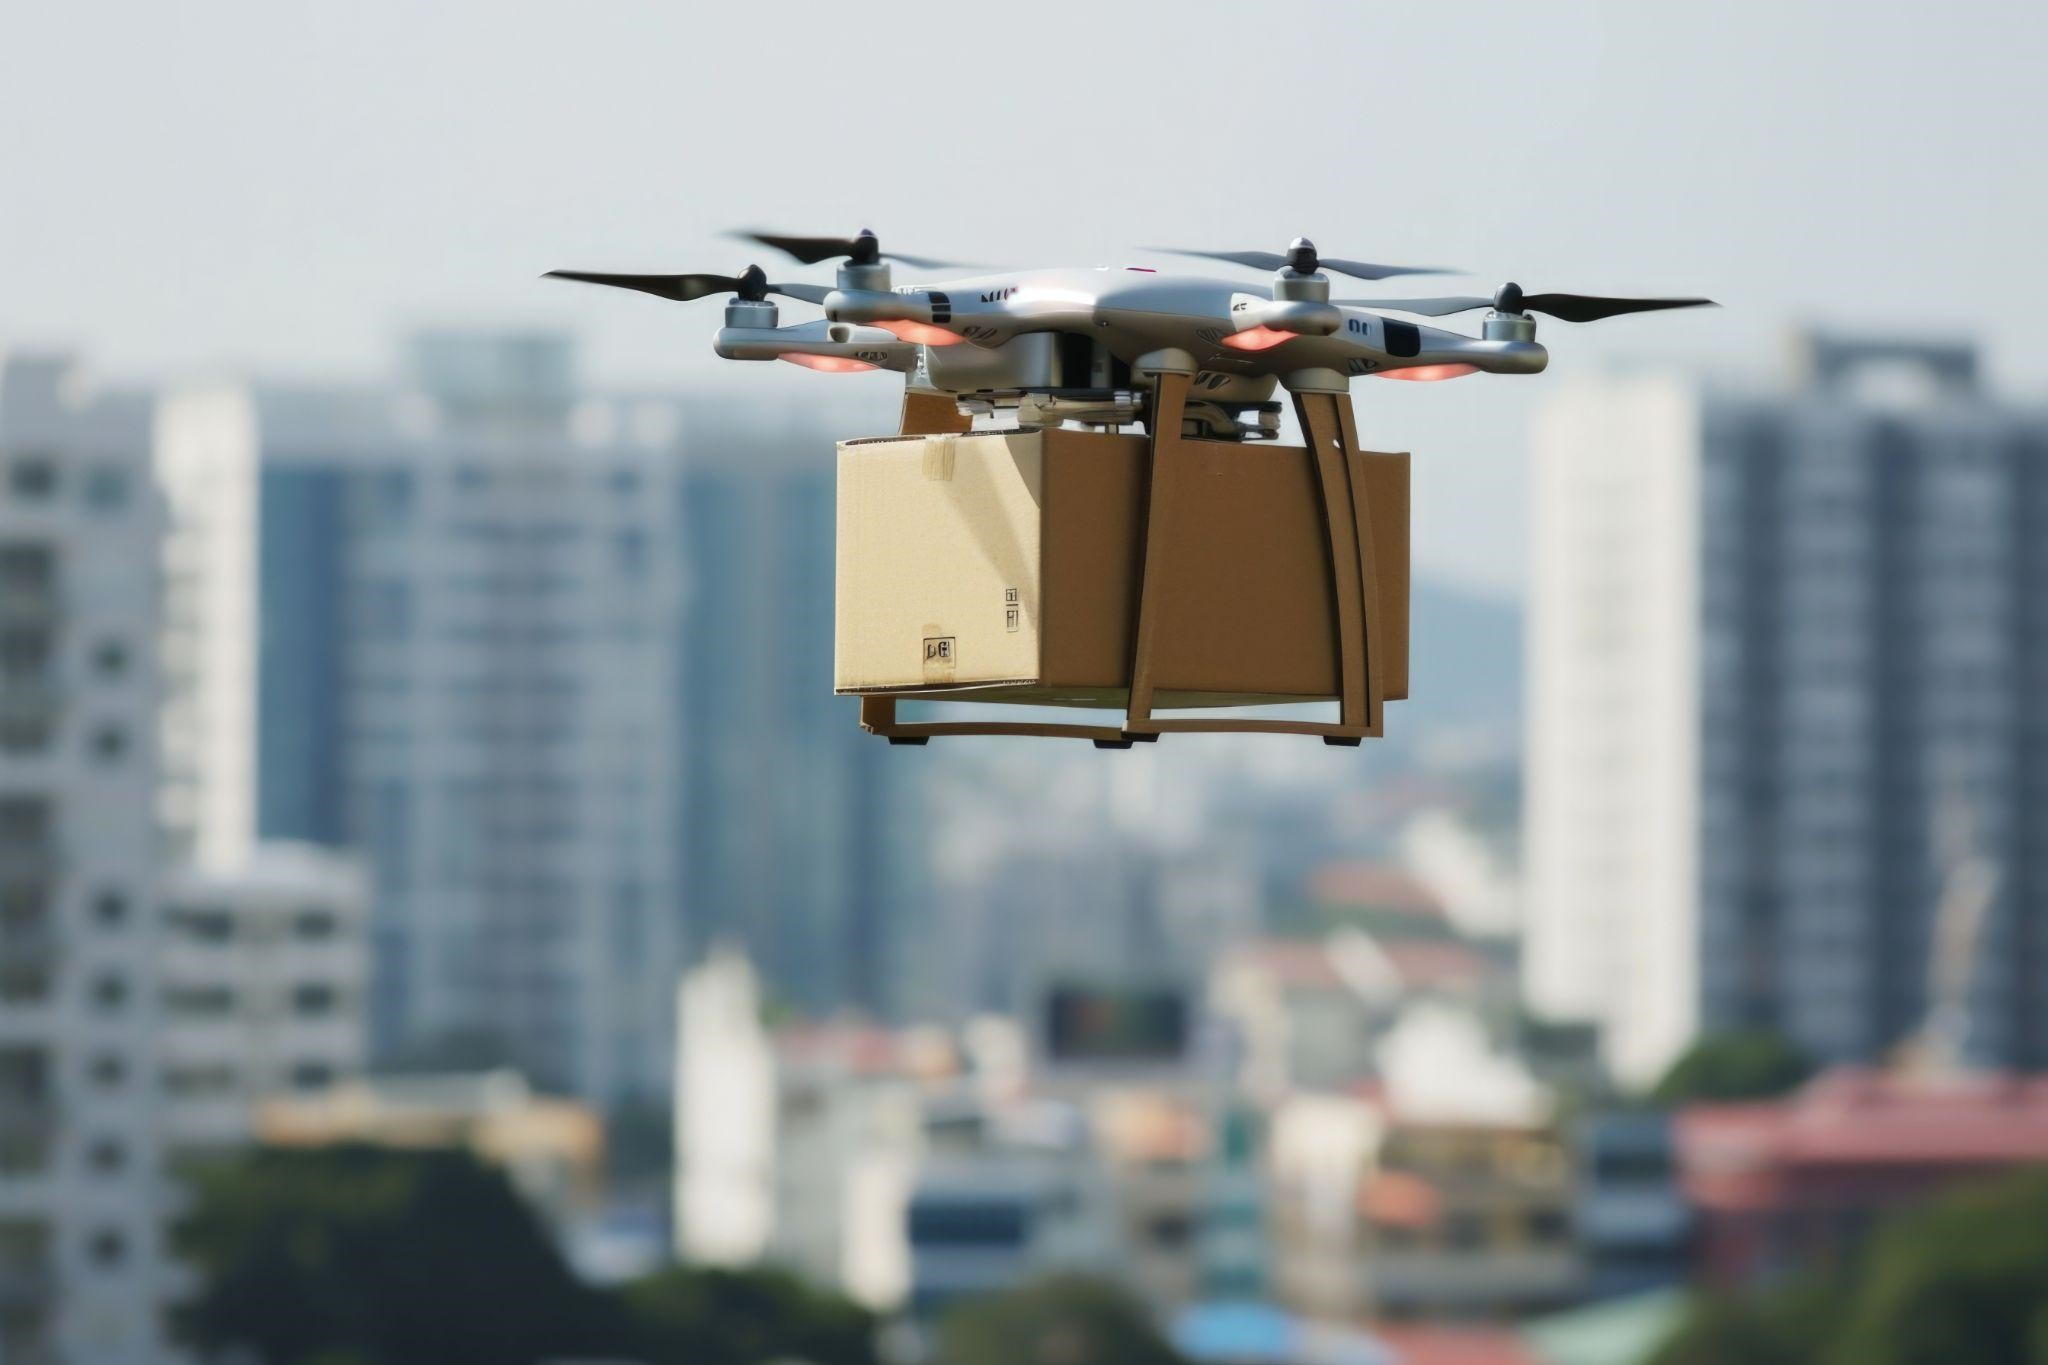

### Batch Testing

In [1]:
import matplotlib.pyplot as plt
import os
import re
from numpy import eye
from pathlib import Path
from typing import Literal, Union
import numpy as np
import matplotlib.pyplot as plt
from problog import get_evaluatable

# The imports we will need to run Probabilistic Mission Design
from promis_project import (StaRMap, ProMis, 
                            PolarLocation, CartesianMap, CartesianLocation, CartesianRasterBand, CartesianCollection,
                            OsmLoader
                           )
from langda import langda_solve
save_dir = Path("/Users/zhenzhili/MASTERTHESIS/#Expert_System_Design/examples/promis/data")
current_dir = Path("/Users/zhenzhili/MASTERTHESIS/#Expert_System_Design/examples/promis/")
save_dir.mkdir(parents=True, exist_ok=True)

promis_dir /Users/zhenzhili/MASTERTHESIS/#Expert_System_Design/examples/promis/promis_project


In [2]:
import re
import os
import logging
import ast

from pathlib import Path
from langda import langda_solve
from promis_execute_new import promis_execution, set_path
from problog import get_evaluatable



# Enable logging
logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    level=logging.INFO
)
logger = logging.getLogger(__name__)

def get_coordinate(model_name, msg_dict):
    """获取坐标信息"""
    danger_rules_string = """
% Your model here
% Earth constant
meter_per_degree(111194.93). % R * π / 180 ≈ 111194.93 meters/degree

langda(LLM:"According to the user: /* User */, the coordinate of the user is at:
please form as: user_location(X,Y).
(X and Y are longitude and latitude)", LOT:"search with 'The geographical coordinates of ... is'").


langda(LLM:"According to the police: /* Police */, the coordinate of the special zone is at:
please form as: special_zone_location(X,Y).
(X and Y are longitude and latitude)",LOT:"None").

relative_offset(NorthOffset, EastOffset) :-
langda(LLM:"The location of the danger zone relative to the user, in meters, calculated based on user_location and special_zone_location above
The conversion of longitude should take into account the influence of latitude",FUP:"false").

query(relative_offset(NorthOffset, EastOffset)).
query(user_location(North, East)).
"""
    while(True):
        try:
            from problog import get_evaluatable
            special_model = langda_solve("double_dc", danger_rules_string, model_name, 
                        prefix="telegram_bot", langda_ext=msg_dict, 
                        load=False)
            print(special_model)
            special_model = special_model.strip("'")
            from problog import get_evaluatable
            special_result = get_evaluatable().create_from(special_model).evaluate()

            pattern = r"(\w+)\(\s*(-?\d+\.\d+),\s*(-?\d+\.\d+)\s*\)"
            result_list = []
            for key in special_result:
                match = re.match(pattern, str(key))
                if match:
                    predicate, x, y = match.groups()
                    result_list.append((float(x),float(y)))
                    print(f"predicate = {predicate}, x = {x}, y = {y}")
            print(result_list)
            (offset_x, offset_y), (user_x, user_y) = result_list
            with open(save_dir / "get_coordinate.txt", "w") as f:
                f.write(f"({user_x}, {user_y}), ({offset_x}, {offset_y})")
            return user_x, user_y, offset_x, offset_y
        except Exception as e:
            logger.error(f"Error in get_coordinate: {e}")
            continue



def validate_path(model_name, msg_dict):
    """验证飞行路径"""    
    danger_rules_string = f"""
langda(LLM:"According to the user: /* Ask */, 
please extract the points and form as: fly([]).
store all the points inside the list, for example [(0,0),(50,50),(50,100)] ").

query(fly(X)).
"""
    
    # 使用传入的msg_dict而不是硬编码
    special_model = langda_solve("single_dc", danger_rules_string, model_name, 
                prefix="telegram_bot_fly", langda_ext=msg_dict,
                load=False)
    special_model = special_model.strip("'")
    special_result = get_evaluatable().create_from(special_model).evaluate()
    
    key = next(iter(special_result))  # 提取唯一键

    # 用正则找出中括号部分
    match = re.search(r"fly\((\[.*\])\)", str(key))
    if match:
        list_str = match.group(1)       # 获取 "[(-230, 200), ..., (0, 0)]"
        coord_list = ast.literal_eval(list_str)  # 安全地解析为 Python 列表
        print(f"Parsed coordinates: {coord_list}")
        
        # 修正set_path调用，添加save_dir参数
        valid_result = set_path(0, 0, coord_list, save_dir)

        return valid_result
    else:
        logger.error("Could not extract coordinate list from result")
        return None
            



In [3]:
import os
from numpy import eye
from pathlib import Path
from typing import Literal, Union
import numpy as np
import matplotlib.pyplot as plt

# The imports we will need to run Probabilistic Mission Design
from promis_project import (StaRMap, ProMis, 
                            PolarLocation, CartesianMap, CartesianLocation, CartesianRasterBand, CartesianCollection,
                            OsmLoader
                           )

def promis_execution2(generated_logic:str, special_zone_location:tuple, operator_location, city_attr:Union[Literal["darmstadt","berlin","frankfurt"], tuple] = "darmstadt", load_uam=True):
    """
    args:
        generated_logic: from langda
        special_zone_location: 
        operator_location: 
        city_attr: name of the city, one of "darmstadt","berlin","frankfurt"
        load_uam: load already existing uam file
    """

    # The features we will load from OpenStreetMap
    # The dictionary key will be stored as the respective features location_type
    # The dictionary value will be used to query the relevant geometry via Overpass
    feature_description = {
        "park": "['leisure' = 'park']",
        "primary": "['highway' = 'primary']",
        "primary_link": "['highway' = 'primary_link']",
        "secondary": "['highway' = 'secondary']",
        "secondary_link": "['highway' = 'secondary_link']",
        "tertiary": "['highway' = 'tertiary']",
        "service": "['highway' = 'service']",
        "crossing": "['footway' = 'crossing']",
        "bay": "['natural' = 'bay']",
        "rail": "['railway' = 'rail']",
    }

    # Covariance matrices for some of the features
    # Used to draw random translations representing uncertainty for the respective features
    covariance = {
        "primary": 15.0 * eye(2),
        "primary_link": 15.0 * eye(2),
        "secondary": 10.0 * eye(2),
        "secondary_link": 10.0 * eye(2),
        "tertiary": 5 * eye(2),
        "service": 2.5 * eye(2),
        "operator": 20 * eye(2),
    }

    # The mission area, points that will be estimated from 25 samples and points that will be interpolated
    # if city_attr == "darmstadt":
    #     origin = PolarLocation(latitude=49.878091, longitude=8.654052) # Darmstadt
    # elif city_attr == "frankfurt":
    #     origin = PolarLocation(latitude=50.110924, longitude=8.682127) # Frankfurt
    # elif city_attr == "berlin":
    #     origin = PolarLocation(latitude=52.5186, longitude=13.4081) # Berlin
    # elif isinstance(city_attr, tuple):
    origin = PolarLocation(latitude=operator_location[0], longitude=operator_location[1])

    width, height = 1000.0, 1000.0
    number_of_random_maps = 20

    support = CartesianRasterBand(origin, (26, 26), width, height)  # This is the set of points that will be directly computed through sampling (expensive)
    target = CartesianRasterBand(origin, (161, 161), width, height)  # This is the set of points that will be interpolated from the support set (cheap)

    if not load_uam:
        print("Building Uncertainty Annotated Map (UAM)...")
        # Setting up the Uncertainty Annotated Map from OpenStreetMap data 49.875, 8.6563899999
        uam = None
        uam = OsmLoader(origin, (width, height), feature_description).to_cartesian_map()
        uam.features.append(CartesianLocation(0, 0, location_type="operator"))  # We can manually add additional features
        uam.features.append(CartesianLocation(special_zone_location[0], special_zone_location[1], location_type="special_zone"))  # We can manually add additional features
        uam.apply_covariance(covariance)  # Assigns the covariance matrices defined earlier
        uam.save(f"{save_dir}/uam_{city_attr}.pkl")  # We can save and load these objects to avoid recomputation

    try:
        print("Initializing StaRMap...")
        # Setting up the probabilistic spatial relations from the map data
        star_map = StaRMap(target, CartesianMap.load(f"{save_dir}/uam_{city_attr}.pkl"))
        star_map.initialize(support, number_of_random_maps, generated_logic)  # This estimates all spatial relations that are relevant to the given logic
        # star_map.add_support_points(support, number_of_random_maps, ["distance"], ["primary"])  # Alternatively, we can estimate for specific relations
        star_map.save(f"{save_dir}/star_map_{city_attr}.pkl")

        print("Running ProMis solver...")
        # Solve the mission area with ProMis
        promis = ProMis(StaRMap.load(f"{save_dir}/star_map_{city_attr}.pkl"))
        landscape = promis.solve(support, generated_logic, n_jobs=4, batch_size=1)
        landscape.save(f"{save_dir}/landscape.pkl")

    except Exception as e:
        print(e)
        return False

    set_path(0, 0, [(0,0)],save_dir)

    return True

def get_confidence_at_point(landscape, east: float, north: float) -> float:

    # 找到最接近的网格点
    distances = np.sqrt((landscape.data.east - east)**2 + 
                        (landscape.data.north - north)**2)
    closest_idx = distances.idxmin()
    return landscape.data.loc[closest_idx, 'v0']

def set_path(x_pt, y_pt, path, save_dir):
    """
    args:
        x_pt, y_pt: will be marked as special mark on the map
        save_dir: save directory
    """
    print("Rendering mission landscape...")
    landscape = CartesianCollection.load(f"{save_dir}/landscape.pkl")

    print(get_confidence_at_point(landscape, x_pt, y_pt))
    image = landscape.scatter(s=0.4, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=1)
    cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=30, pad=0.02)
    cbar.ax.set_yticklabels(['0.0', '0.5', '1.0'])
    cbar.solids.set(alpha=1)

    ticks = [-500, 0, 500]
    labels = ["-500", "0", "500"]
    
    plt.xlabel("Easting / km")
    plt.ylabel("Northing / km")
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
    plt.title("P(mission_landscape)")
    confidence_list = []
    # for i, path in enumerate(path_lists):
    #     confidence_list = []
    valid = True
    for (x,y) in path:
        confidence = np.around(get_confidence_at_point(landscape, x, y),3)
        if confidence < 0.4:
            confidence_list.append(f"Invalid")
            valid = False
        else:
            confidence_list.append(confidence)
    if valid:
        marker = "."
    else:
        marker = "x"
    plt.plot(*zip(*path), 
            marker=marker,
            markersize=5,
            linewidth=1.5,
            alpha=0.8,
            # label=f'Path{i}'
            )
    
    print(f"Path: {valid}",confidence_list)
    
    plt.title("Path Validity Visualization")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.axis('equal')

    # —— Special mark at x_pt, y_pt —— #
    plt.scatter(
        x_pt, y_pt,
        marker='*',
        s=100,
        c='red',
        edgecolors='black',
        linewidths=1.2,
        zorder=5          # 确保点画在最上层
    )
    if not len(path) > 1:
        plt.savefig(
            f"{save_dir}/mission_landscape.png", 
            dpi=100,
            format='png',
            bbox_inches='tight',
            transparent=False)
        plt.close()
        print(f"Landscape plot saved to mission_landscape.png")
    else:
        plt.savefig(
            f"{save_dir}/validation_path.png", 
            dpi=100,
            format='png',
            bbox_inches='tight',
            transparent=False)
        plt.close()
        print(f"Landscape plot saved to validation_path.png")
    return confidence_list

In [4]:
generated_logic = """
% UAV properties
initial_charge ~ normal(90, 5).
charge_cost ~ normal(-0.1, 0.2).
weight ~ normal(0.2, 0.1).
% Real-time weather conditions:
weather(clear, 5, 25).
battery_efficiency(Efficiency) :-
 weather(_, _, Temp),
 (Temp < 0, Efficiency = 0.8; % Very cold
 Temp >= 0, Temp < 10, Efficiency = 0.85; % Cold
 Temp >= 10, Temp =< 35, Efficiency = 1.0; % Normal
 Temp > 35, Efficiency = 0.95 % Hot
 ).
 
% Visual line of sight
vlos(X) :-
    weather(Condition, _, _),
    (
        Condition = light_rain, distance(X, operator) < 20;
        Condition = cloudy, distance(X, operator) < 50;
        Condition = clear, distance(X, operator) < 100;
        Condition = clear, over(X, bay), distance(X, operator) < 400
    ).
% Sufficient charge to return to operator
can_return(X) :-
 weather(_, WindSpeed, _),
 W is 1 + WindSpeed / 25,
 battery_efficiency(E),
 B is initial_charge, O is charge_cost,
 D is distance(X, operator), 0 < B + (2 * O * D * W / E).
sensitive_section(X) :-
 
 distance(X, special_zone) < 50.
% Permits related to local features
permits(X) :- 
 distance(X, service) < 15; distance(X, primary) < 15;
 distance(X, secondary) < 10; distance(X, tertiary) < 5;
 distance(X, crossing) < 5; distance(X, rail) < 5;
 over(X, park).
% Definition of a valid mission
landscape(X) :- 
 \+ sensitive_section(X),
 (
 vlos(X), weight < 25, can_return(X); 
 permits(X), can_return(X)
 ).
"""

In [5]:
# msg_dict = {"User":"Ich bin am Innenstadtcampus der Technischen Universität Darmstadt.",
#          "Police":"Today, the police found a bomb at (49.873094, 8.658995) coordinates. Please stay at least 50 meters away."}


# # special_zone_location = (-200,200)
# # operator_location = (49.875, 8.65639)
# city_attr = "darmstadt"
# model_name = "deepseek-chat"
# # user_x, user_y, offset_x, offset_y = get_coordinate("deepseek-chat", msg_dict)
# danger_rules_string = """
# % Your model here
# % Earth constant
# meter_per_degree(111194.93). % R * π / 180 ≈ 111194.93 meters/degree

# langda(LLM:"According to the user: /* User */, the coordinate of the user is at:
# please form as: user_location(X,Y).
# (X and Y are longitude and latitude)", LOT:"search with 'The geographical coordinates of ... is'").


# langda(LLM:"According to the police: /* Police */, the coordinate of the special zone is at:
# please form as: special_zone_location(X,Y).
# (X and Y are longitude and latitude)").

# relative_offset(NorthOffset, EastOffset) :-
# langda(LLM:"The location of the danger zone relative to the user, in meters, calculated based on user_location and special_zone_location above
# The conversion of longitude should take into account the influence of latitude").

# query(relative_offset(NorthOffset, EastOffset)).
# query(user_location(North, East)).
# """
# special_model = langda_solve("double_dc", danger_rules_string, model_name, 
#             prefix="telegram_bot", langda_ext=msg_dict, 
#             load=False)
# special_result = get_evaluatable().create_from(special_model).evaluate()

# pattern = r"(\w+)\(\s*(-?\d+\.\d+),\s*(-?\d+\.\d+)\s*\)"
# result_list = []
# for key in special_result:
#     match = re.match(pattern, str(key))
#     if match:
#         predicate, x, y = match.groups()
#         result_list.append((float(x),float(y)))
#         print(f"predicate = {predicate}, x = {x}, y = {y}")
# print(result_list)
# (offset_x, offset_y), (user_x, user_y) = result_list
# with open(save_dir / "get_coordinate.txt", "w") as f:
#     f.write(f"({user_x}, {user_y}), ({offset_x}, {offset_y})")


## Test: Trajectories

In [6]:

model_name = "deepseek-chat"
promis_prompt = current_dir / "promis_normal_drone.pl"

with open(promis_prompt, "r") as f:
    rules_string = f.read()

prefix = "2"
user1 = "Ich bin am Innenstadtcampus der Technischen Universität Darmstadt."
user2 = "Ich bin jetzt am Frankfurt Hauptbahnhof"
police = "There is a special event going on at 49.87495, 8.65941, drones are prohibited there."
police2 = "There is a special event going on at 49.87495, 8.65941, drones are prohibited there."
ask1 = "I just updated my flying plan: [(-230,200), (-215,195), (-200,200), (-185,190), (-170,195), (-150,195), (-130,180),(-115,175), (-100,150), (-90,125), (-80,100), (-60,80), (-40,60), (-30,40),(-20,20), (-13,13), (-7,7), (0,0)], please check if it's valid or not"
ask2 = "My drone is now at(-100, -265), I plan to fly it back through: (-80, -240), (-60, -215), (-40, -190), (-20, -165), (0, -140), (20, -115), (10, -90), (0, -65), (-10, -40), (-5, -20), (0, 0)"
user_x, user_y, offset_x, offset_y = get_coordinate(model_name, {"User":user1,"Police":police})

result = langda_solve("double_dc", rules_string, model_name, 
                        prefix=f"telegram_bot_{prefix}", langda_ext={"User":user1,"Police":police},
                        load=False)

2025-07-02 21:29:47,058 - root - INFO - File saved successfully: /Users/zhenzhili/MASTERTHESIS/#Expert_System_Design/examples/promis/history/steps/telegram_bot/langda_dict_prompt.txt


### =========== processing init_node =========== ###
[{'LOT': "search with 'The geographical coordinates of ... is'", 'NET': None, 'LLM': 'According to the user: /* User */, the coordinate of the user is at:\nplease form as: user_location(X,Y).\n(X and Y are longitude and latitude)', 'FUP': 'True', 'HEAD': '', 'HASH': 'CE079308'}, {'LOT': 'None', 'NET': None, 'LLM': 'According to the police: /* Police */, the coordinate of the special zone is at:\nplease form as: special_zone_location(X,Y).\n(X and Y are longitude and latitude)', 'FUP': 'True', 'HEAD': '', 'HASH': '53C81432'}, {'LOT': None, 'NET': None, 'LLM': 'The location of the danger zone relative to the user, in meters, calculated based on user_location and special_zone_location above\nThe conversion of longitude should take into account the influence of latitude', 'FUP': 'false', 'HEAD': 'relative_offset(NorthOffset, EastOffset) ', 'HASH': '27C37B02'}]
{'CE079308': 'user_location(49.87500, 8.65639).', '27C37B02': 'relative_offset

2025-07-02 21:29:47,498 - httpx - INFO - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"


KeyboardInterrupt: 

In [ ]:
import re
import os
import logging
import ast

from pathlib import Path
from langda import langda_solve
from promis_execute_new import promis_execution, set_path
from problog import get_evaluatable
import matplotlib.pyplot as plt
import os
import re
from numpy import eye
from pathlib import Path
from typing import Literal, Union
import numpy as np
import matplotlib.pyplot as plt
from problog import get_evaluatable

# The imports we will need to run Probabilistic Mission Design
from promis_project import (StaRMap, ProMis, 
                            PolarLocation, CartesianMap, CartesianLocation, CartesianRasterBand, CartesianCollection,
                            OsmLoader
                           )
from langda import langda_solve
save_dir = Path("/Users/zhenzhili/MASTERTHESIS/#Expert_System_Design/examples/promis/data")
current_dir = Path("/Users/zhenzhili/MASTERTHESIS/#Expert_System_Design/examples/promis/")
save_dir.mkdir(parents=True, exist_ok=True)


# Enable logging
logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    level=logging.INFO
)
logger = logging.getLogger(__name__)

def get_coordinate(model_name, msg_dict):
    """获取坐标信息"""
    danger_rules_string = """
% Your model here
% Earth constant
meter_per_degree(111194.93). % R * π / 180 ≈ 111194.93 meters/degree

langda(LLM:"According to the user: /* User */, the coordinate of the user is at:
please form as: user_location(X,Y).
(X and Y are longitude and latitude)", LOT:"search with 'The geographical coordinates of ... is'").


langda(LLM:"According to the police: /* Police */, the coordinate of the special zone is at:
please form as: special_zone_location(X,Y).
(X and Y are longitude and latitude)",LOT:"None").

relative_offset(NorthOffset, EastOffset) :-
langda(LLM:"The location of the danger zone relative to the user, in meters, calculated based on user_location and special_zone_location above
The conversion of longitude should take into account the influence of latitude",FUP:"false").

query(relative_offset(NorthOffset, EastOffset)).
query(user_location(North, East)).
"""
    while(True):
        try:
            from problog import get_evaluatable
            special_model = langda_solve("double_dc", danger_rules_string, model_name, 
                        prefix="telegram_bot", langda_ext=msg_dict, 
                        load=False)
            print(special_model)
            special_model = special_model.strip("'")
            from problog import get_evaluatable
            special_result = get_evaluatable().create_from(special_model).evaluate()

            pattern = r"(\w+)\(\s*(-?\d+\.\d+),\s*(-?\d+\.\d+)\s*\)"
            result_list = []
            for key in special_result:
                match = re.match(pattern, str(key))
                if match:
                    predicate, x, y = match.groups()
                    result_list.append((float(x),float(y)))
                    print(f"predicate = {predicate}, x = {x}, y = {y}")
            print(result_list)
            (offset_x, offset_y), (user_x, user_y) = result_list
            with open(save_dir / "get_coordinate.txt", "w") as f:
                f.write(f"({user_x}, {user_y}), ({offset_x}, {offset_y})")
            return user_x, user_y, offset_x, offset_y
        except Exception as e:
            logger.error(f"Error in get_coordinate: {e}")
            continue



def validate_path(model_name, msg_dict):
    """验证飞行路径"""    
    danger_rules_string = f"""
langda(LLM:"According to the user: /* Ask */, 
please extract the points and form as: fly([]).
store all the points inside the list, for example [(0,0),(50,50),(50,100)] ").

query(fly(X)).
"""
    
    # 使用传入的msg_dict而不是硬编码
    special_model = langda_solve("single_dc", danger_rules_string, model_name, 
                prefix="telegram_bot_fly", langda_ext=msg_dict,
                load=False)
    special_model = special_model.strip("'")
    special_result = get_evaluatable().create_from(special_model).evaluate()
    
    key = next(iter(special_result))  # 提取唯一键

    # 用正则找出中括号部分
    match = re.search(r"fly\((\[.*\])\)", str(key))
    if match:
        list_str = match.group(1)       # 获取 "[(-230, 200), ..., (0, 0)]"
        coord_list = ast.literal_eval(list_str)  # 安全地解析为 Python 列表
        print(f"Parsed coordinates: {coord_list}")
        
        # 修正set_path调用，添加save_dir参数
        valid_result = set_path(0, 0, coord_list, save_dir)

        return valid_result
    else:
        logger.error("Could not extract coordinate list from result")
        return None
            



promis_dir /Users/zhenzhili/MASTERTHESIS/#Expert_System_Design/examples/promis/promis_project


### Flight Path

In [90]:
model_name = "deepseek-chat"
promis_prompt = current_dir / "promis_normal_drone.pl"

# success = promis_execution2(result, (offset_x, offset_y), (user_x, user_y), city_attr=f"darmstadt_{prefix}",load_uam=False)
ask1 = "I just updated my flying plan: [(-230,200), (-215,195), (-200,200), (-185,190), (-170,195), (-150,195), (-130,180),(-115,175), (-100,150), (-90,125), (-80,100), (-60,80), (-40,60), (-30,40),(-20,20), (-13,13), (-7,7), (0,0)], please check if it's valid or not"
ask2 = "向东北方向飞, 每20米纪录一个航点, 到300米处停下"
ask3 = "asdasdasdasdas"
ask = "my drone is at (200,200) it will come back to me"

valid_result = validate_path(model_name, {"Ask":ask})

2025-07-03 12:48:41,658 - root - INFO - File saved successfully: /Users/zhenzhili/MASTERTHESIS/#Expert_System_Design/examples/promis/history/steps/telegram_bot_fly/langda_dict_prompt.txt


### =========== processing init_node =========== ###
[{'LOT': None, 'NET': None, 'LLM': 'According to the user: /* Ask */, \nplease extract the points and form as: fly([]).\nstore all the points inside the list, for example [(0,0),(50,50),(50,100)] ', 'FUP': 'True', 'HEAD': '', 'HASH': '9EC55593'}]
{'9EC55593': 'fly([(0, 0), (20, 20), (40, 40), (60, 60), (80, 80), (100, 100), (120, 120), (140, 140), (160, 160), (180, 180), (200, 200), (220, 220), (240, 240), (260, 260), (280, 280), (300, 300)]).'}
prompt from external received: my drone is at (200,200) it will come back to me
[{'9EC55593': None}]
processing _decide_next_init ...
### =========== ### current round: 0 ### =========== ###
### =========== processing generate_node =========== ###
Executing first chain: Code generation with tools...


> Entering new AgentExecutor chain...


2025-07-03 12:48:42,319 - httpx - INFO - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"


Here is the completed code based on your requirements:

```problog
% Define the points the drone will fly through
fly([(200,200), (150,150), (100,100), (50,50), (0,0)]).

% Query to retrieve the flight path
query(fly(X)).
```

This code defines the flight path of the drone as a list of points starting from `(200,200)` and ending at `(0,0)`. The `query(fly(X))` allows you to retrieve the flight path. Adjust the points as needed.

> Finished chain.
*** Generated New Code ***
 % Define the points the drone will fly through
fly([(200,200), (150,150), (100,100), (50,50), (0,0)]).

% Query to retrieve the flight path
query(fly(X)).

Executing second chain: Code formatting...


2025-07-03 12:48:50,891 - httpx - INFO - HTTP Request: POST https://api.deepseek.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-03 12:48:56,048 - root - INFO - File saved successfully: /Users/zhenzhili/MASTERTHESIS/#Expert_System_Design/examples/promis/history/steps/telegram_bot_fly/formatted_gnrtprompt_0_prompt.txt
2025-07-03 12:48:56,050 - root - INFO - File saved successfully: /Users/zhenzhili/MASTERTHESIS/#Expert_System_Design/examples/promis/history/steps/telegram_bot_fly/#gnrt_result_0_result.txt
2025-07-03 12:48:56,052 - root - INFO - File saved successfully: /Users/zhenzhili/MASTERTHESIS/#Expert_System_Design/examples/promis/history/steps/telegram_bot_fly/#gnrt_0_codes.txt
2025-07-03 12:48:56,069 - problog - INFO - Grounding: 0.0021s
2025-07-03 12:48:56,070 - problog - INFO - Compiling SDDHAL: 0.0008s
2025-07-03 12:48:56,076 - root - INFO - File saved successfully: /Users/zhenzhili/MASTERTHESIS/#Expert_System_Design/examples/promis/history/telegram_bot_fly_final_code.pl
2025

### =========== processing summary_node =========== ###
*** test_result: ***

Running problog_test_tool...
Error evaluating Problog model:
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zhenzhili/MASTERTHESIS/#Expert_System_Design/examples/promis/promis_project/problog/problog/tasks/dcproblog/sdd_formula.py", line 39, in get_evaluator
    assert semiring
           ^^^^^^^^
AssertionError
{'9EC55593': 'fly([(200,200), (150,150), (100,100), (50,50), (0,0)]).'}
*** Running_time: 14s, 1 rounds in total.


AssertionError: 

In [ ]:
# success = promis_execution(generated_logic, (-200, 200), (49.875,8.65639), city_attr="darmstadt",load_uam=False)
path_lists = [
    [(-50,265), (-75,265), (-100,265), (-120,248), (-140,230), (-145,215), (-150,200), (-137,177), (-123,153), (-110,130), (-95,115), (-80,100), (-63,83), (-47,67), (-30,50), (-20,33), (-10,17), (0,0)],
    [(110,-370), (105,-360), (100,-350), (90,-335), (80,-320), (70,-300), (60,-280), (55,-250), (50,-220), (50,-190), (50,-160), (50,-138), (50,-115), (23,-98), (-5,-80), (3,-55), (10,-30), (7,-20), (4,-10), (0,0)],
    [(-350,50), (-325,45), (-300,40), (-260,40), (-220,40), (-200,30), (-180,20), (-150,20), (-120,20), (-90,10), (-60,0), (-40,0), (-20,0), (0,0)],
    [(-350,50), (-330,25), (-310,0), (-295,-20), (-280,-40), (-270,-65), (-260,-90), (-260,-110), (-260,-130), (-245,-105), (-230,-80), (-205,-70), (-180,-60), (-150,-45), (-120,-30), (-90,-30), (-60,-30), (-43,-30), (-25,-30), (-13,-20), (-7,-10), (0,0)],
    [(-230,290), (-215,275), (-200,260), (-185,240), (-170,220), (-150,210), (-130,200), (-115,175), (-100,150), (-90,125), (-80,100), (-60,80), (-40,60), (-30,40), (-20,20), (-13,13), (-7,7), (0,0)],
    [(-350,50), (-325,45), (-300,40), (-275,60), (-250,80), (-225,80), (-200,80), (-185,90), (-170,100), (-145,115), (-120,130), (-105,150), (-90,170), (-65,170), (-40,170), (-20,180), (0,190), (20,170), (40,150), (35,130), (30,110), (10,85), (-10,60), (-10,40), (-10,20), (-7,13), (-3,7), (0,0)],
    [(-90,-278), (-80,-290), (-60,-290), (-20,-290), (-20,-270), (-20,-250), (-10,-235), (0,-220), (15,-220), (30,-210), (38,-195), (45,-180), (43,-160), (40,-140), (30,-120), (20,-100), (10,-90), (0,-80), (-10,-60), (-20,-40), (-13,-27), (-7,-13), (0,0)],
    [(200,40), (190,20), (180,0), (160,-10), (140,-20), (120,-25), (100,-30), (80,-25), (60,-20), (45,-15), (30,-10), (15,-5), (0,0)],
    [(135,210), (135,195), (135,180), (123,160), (110,140), (90,145), (70,150), (50,140), (30,130), (15,115), (0,100), (-8,80), (-15,60), (-23,45), (-30,30), (-20,20), (-10,10), (0,0)],
    [(-50, 265), (-70, 240), (-90, 210), (-110, 180), (-130, 150), (-150, 120), (-120, 90), (-90, 60), (-60, 30), (-30, 15), (0, 0)],
    [(110, -370), (90, -350), (70, -330), (50, -300), (30, -270), (10, -240), (-10, -210), (-30, -180), (-50, -150), (-40, -120), (-30, -90), (-20, -60), (-10, -30), (0, 0)],   
    [(-100, -265), (-80, -240), (-60, -215), (-40, -190), (-20, -165), (0, -140), (20, -115), (10, -90), (0, -65), (-10, -40), (-5, -20), (0, 0)],
    [(200, 40), (180, 30), (160, 20), (140, 10), (120, 0), (100, -10), (80, -5), (60, 0), (40, 5), (20, 10), (10, 5), (0, 0)],
    [(135, 210), (120, 190), (105, 170), (90, 150), (75, 130), (60, 110), (45, 90), (30, 70), (15, 50), (10, 30), (5, 15), (0, 0)],
    [(-50, 265), (-30, 240), (-10, 215), (10, 190), (30, 165), (50, 140), (40, 115), (30, 90), (20, 65), (10, 40), (5, 20), (0, 0)],
    [(110, -370), (100, -340), (90, -310), (80, -280), (70, -250), (60, -220), (80, -190), (100, -160), (90, -130), (80, -100), (70, -70), (60, -40), (30, -20), (0, 0)],
    [(-350, 50), (-320, 70), (-290, 90), (-260, 110), (-230, 130), (-200, 150), (-170, 130), (-140, 110), (-110, 90), (-80, 70), (-50, 50), (-25, 30), (0, 0)],
    [(-230, 290), (-200, 280), (-170, 270), (-140, 260), (-110, 250), (-80, 240), (-50, 220), (-20, 200), (10, 180), (40, 160), (50, 130), (40, 100), (30, 70), (20, 40), (10, 20), (0, 0)],
    [(-100, -265), (-80, -240), (-60, -215), (-40, -190), (-20, -165), (0, -140), (20, -115), (40, -90), (60, -65), (80, -40), (70, -20), (50, -10), (25, -5), (0, 0)],
    [(200, 40), (180, 60), (160, 80), (140, 100), (120, 120), (100, 140), (80, 120), (60, 100), (40, 80), (20, 60), (10, 40), (5, 20), (0, 0)],
    [(135, 210), (110, 200), (85, 190), (60, 180), (35, 170), (10, 160), (-15, 150), (-40, 140), (-20, 120), (0, 100), (20, 80), (40, 60), (30, 40), (20, 20), (10, 10), (0, 0)]
]

In [87]:
import os
from numpy import eye
from pathlib import Path
from typing import Literal, Union
import numpy as np
import matplotlib.pyplot as plt

# The imports we will need to run Probabilistic Mission Design
from promis_project import (StaRMap, ProMis, 
                            PolarLocation, CartesianMap, CartesianLocation, CartesianRasterBand, CartesianCollection,
                            OsmLoader
                           )

def promis_execution(generated_logic:str, special_zone_location:tuple, operator_location, city_attr:Union[Literal["darmstadt","berlin","frankfurt"], tuple] = "darmstadt", load_uam=True):
    """
    args:
        generated_logic: from langda
        special_zone_location: 
        operator_location: 
        city_attr: name of the city, one of "darmstadt","berlin","frankfurt"
        load_uam: load already existing uam file
    """
    current_dir = Path(os.path.dirname(os.path.abspath(__file__)))
    save_dir = current_dir / "data"
    save_dir.mkdir(parents=True, exist_ok=True)

    # The features we will load from OpenStreetMap
    # The dictionary key will be stored as the respective features location_type
    # The dictionary value will be used to query the relevant geometry via Overpass
    feature_description = {
        "park": "['leisure' = 'park']",
        "primary": "['highway' = 'primary']",
        "primary_link": "['highway' = 'primary_link']",
        "secondary": "['highway' = 'secondary']",
        "secondary_link": "['highway' = 'secondary_link']",
        "tertiary": "['highway' = 'tertiary']",
        "service": "['highway' = 'service']",
        "crossing": "['footway' = 'crossing']",
        "bay": "['natural' = 'bay']",
        "rail": "['railway' = 'rail']",
    }

    # Covariance matrices for some of the features
    # Used to draw random translations representing uncertainty for the respective features
    covariance = {
        "primary": 15.0 * eye(2),
        "primary_link": 15.0 * eye(2),
        "secondary": 10.0 * eye(2),
        "secondary_link": 10.0 * eye(2),
        "tertiary": 5 * eye(2),
        "service": 2.5 * eye(2),
        "operator": 20 * eye(2),
    }

    # The mission area, points that will be estimated from 25 samples and points that will be interpolated
    # if city_attr == "darmstadt":
    #     origin = PolarLocation(latitude=49.878091, longitude=8.654052) # Darmstadt
    # elif city_attr == "frankfurt":
    #     origin = PolarLocation(latitude=50.110924, longitude=8.682127) # Frankfurt
    # elif city_attr == "berlin":
    #     origin = PolarLocation(latitude=52.5186, longitude=13.4081) # Berlin
    # elif isinstance(city_attr, tuple):
    origin = PolarLocation(latitude=operator_location[0], longitude=operator_location[1])

    width, height = 1000.0, 1000.0
    number_of_random_maps = 20

    support = CartesianRasterBand(origin, (26, 26), width, height)  # This is the set of points that will be directly computed through sampling (expensive)
    target = CartesianRasterBand(origin, (161, 161), width, height)  # This is the set of points that will be interpolated from the support set (cheap)

    if not load_uam:
        print("Building Uncertainty Annotated Map (UAM)...")
        # Setting up the Uncertainty Annotated Map from OpenStreetMap data 49.875, 8.6563899999
        uam = None
        uam = OsmLoader(origin, (width, height), feature_description).to_cartesian_map()
        uam.features.append(CartesianLocation(0, 0, location_type="operator"))  # We can manually add additional features
        uam.features.append(CartesianLocation(special_zone_location[0], special_zone_location[1], location_type="special_zone"))  # We can manually add additional features
        uam.apply_covariance(covariance)  # Assigns the covariance matrices defined earlier
        uam.save(f"{save_dir}/uam_{city_attr}.pkl")  # We can save and load these objects to avoid recomputation

    try:
        print("Initializing StaRMap...")
        # Setting up the probabilistic spatial relations from the map data
        star_map = StaRMap(target, CartesianMap.load(f"{save_dir}/uam_{city_attr}.pkl"))
        star_map.initialize(support, number_of_random_maps, generated_logic)  # This estimates all spatial relations that are relevant to the given logic
        # star_map.add_support_points(support, number_of_random_maps, ["distance"], ["primary"])  # Alternatively, we can estimate for specific relations
        star_map.save(f"{save_dir}/star_map_{city_attr}.pkl")

        print("Running ProMis solver...")
        # Solve the mission area with ProMis
        promis = ProMis(StaRMap.load(f"{save_dir}/star_map_{city_attr}.pkl"))
        landscape = promis.solve(support, generated_logic, n_jobs=4, batch_size=1)
        landscape.save(f"{save_dir}/landscape.pkl")

    except Exception as e:
        print(e)
        return False

    set_path(0, 0, [(0,0)],save_dir)

    return True

def get_confidence_at_point(landscape, east: float, north: float) -> float:

    # 找到最接近的网格点
    distances = np.sqrt((landscape.data.east - east)**2 + 
                        (landscape.data.north - north)**2)
    closest_idx = distances.idxmin()
    return landscape.data.loc[closest_idx, 'v0']



def set_path(x_pt, y_pt, path, save_dir):
    """
    args:
        x_pt, y_pt: will be marked as special mark on the map
        save_dir: save directory
    """
    if isinstance(path, tuple) and len(path) == 2:
        # 传进来的是单个元组 (x, y)
        path = [path]
    elif isinstance(path, np.ndarray) and path.shape == (2,):
        # 传进来的是 np.array([x, y])
        path = [tuple(path)]
    elif isinstance(path, list) and len(path) and not isinstance(path[0], (list, tuple, np.ndarray)):
        # 传进来的是 [x, y]
        path = [tuple(path)]
    print("Rendering mission landscape...")
    landscape = CartesianCollection.load(f"{save_dir}/landscape.pkl")

    print(get_confidence_at_point(landscape, x_pt, y_pt))
    image = landscape.scatter(s=0.4, plot_basemap=True, rasterized=True, cmap="coolwarm_r", alpha=1)
    cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=30, pad=0.02)
    cbar.ax.set_yticklabels(['0.0', '0.5', '1.0'])
    cbar.solids.set(alpha=1)

    ticks = [-500, 0, 500]
    labels = ["-500", "0", "500"]
    
    plt.xlabel("Easting / km")
    plt.ylabel("Northing / km")
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
    plt.title("P(mission_landscape)")
    
    confidence_list = []
    invalid_points = []  # 存储异常点的坐标
    
    # 检查每个路径点的置信度
    for (x, y) in path:
        confidence = np.around(get_confidence_at_point(landscape, x, y), 3)
        if confidence < 0.4:
            confidence_list.append(f"Invalid")
            invalid_points.append((x, y))  # 记录异常点
        else:
            confidence_list.append(confidence)
    
    # 绘制路径（始终用正常的线条和点）
    if len(path) > 1:
        plt.plot(*zip(*path), 
                marker=".",
                markersize=5,
                linewidth=1.5,
                alpha=0.8,
                color='blue',  # 路径用蓝色
                )
    elif len(path) == 1:
        # 如果只有一个点，单独绘制
        plt.scatter(path[0][0], path[0][1], 
                   marker=".",
                   s=25,
                   color='blue',
                   alpha=0.8)
    
    if invalid_points:
        for (x, y) in invalid_points:
            # 外圈 - 更大半径
            circle1 = plt.Circle((x, y), radius=15, 
                                facecolor='none', edgecolor='blue', 
                                linewidth=2, alpha=0.8, zorder=4)
            plt.gca().add_patch(circle1)
            
            # 内圈 - 更小半径，不同zorder
            # circle2 = plt.Circle((x, y), radius=10, 
            #                     facecolor='none', edgecolor='orange', 
            #                     linewidth=2, alpha=0.6, zorder=3)
            # plt.gca().add_patch(circle2)
            
            # 中心点
            plt.scatter(x, y, marker='o', s=2, c='red', alpha=1.0, zorder=5)
    # 特殊标记点 (x_pt, y_pt)
    plt.scatter(
        x_pt, y_pt,
        marker='*',
        s=100,
        c='red',
        edgecolors='black',
        linewidths=1.2,
        zorder=5,
    )
    
    # 打印置信度信息
    valid_count = len([c for c in confidence_list if c != "Invalid"])
    invalid_count = len(invalid_points)
    print(f"Path Analysis: {valid_count} valid points, {invalid_count} invalid points")
    print(f"Confidence values: {confidence_list}")
    
    plt.title("Path Validity Visualization")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.axis('equal')
    if not len(path) > 1:
        plt.savefig(
            f"{save_dir}/mission_landscape.png", 
            dpi=100,
            format='png',
            bbox_inches='tight',
            transparent=False)
        plt.close()
        print(f"Landscape plot saved to mission_landscape.png")
    else:
        plt.savefig(
            f"{save_dir}/validation_path.png", 
            dpi=100,
            format='png',
            bbox_inches='tight',
            transparent=False)
        plt.close()
        print(f"Landscape plot saved to validation_path.png")
    
    return confidence_list

In [89]:
path = [(250,250), (300,200)]

set_path(0, 0, path, save_dir)



Rendering mission landscape...
1.0
Path Analysis: 0 valid points, 2 invalid points
Confidence values: ['Invalid', 'Invalid']
Landscape plot saved to validation_path.png


['Invalid', 'Invalid']